In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import rasterio as rio
import geopandas as gpd

import os
import json

from pprint import pprint
# from pyretechnics.fuel_models import get_fuel_model, moisturize

from_vals = [
    91,92,93,98,99,
    101,102,103,104,105,106,107,108,109,
    121,122,123,124,
    141,142,143,144,145,146,147,148,149,
    161,162,163,164,165,
    181,182,183,184,185,186,187,188,189,
    201,202,203,204
]

to_vals = [
    1,1,1,1,1,
    2,2,2,2,2,2,2,2,2,
    3,3,3,3,
    4,4,4,4,4,4,4,4,4,
    5,5,5,5,5,
    6,6,6,6,6,6,6,6,6,
    7,7,7,7
]

In [3]:


# static_fuel_model_number  = 1   # R01
# dynamic_fuel_model_number = 101 # GR1

# static_fuel_model  = get_fuel_model(static_fuel_model_number)
# dynamic_fuel_model = get_fuel_model(dynamic_fuel_model_number)

# print("Static Fuel Model: R01")
# pprint(static_fuel_model)

# print("\nDynamic Fuel Model: GR1")
# pprint(dynamic_fuel_model)

# fuel_moisture = (
#     0.05, # dead_1hr
#     0.10, # dead_10hr
#     0.15, # dead_100hr
#     0.00, # dead_herbaceous (will be set by moisturize for dynamic fuel models)
#     0.30, # live_herbaceous
#     0.50, # live_woody
# )

# low_moisture = (
#     0.03, # dead_1hr
#     0.04, # dead_10hr
#     0.05, # dead_100hr
#     0.00, # dead_herbaceous (will be set by moisturize for dynamic fuel models)
#     1.20, # live_herbaceous
#     1.50, # live_woody
# )

In [4]:
# print("Moisturized Static Fuel Model: R01")
# pprint(moisturize(static_fuel_model, fuel_moisture))

In [5]:
# print("\nMoisturized Dynamic Fuel Model: GR1")
# pprint(moisturize(dynamic_fuel_model, fuel_moisture))

---

Load Dataset

---

In [6]:
root_file = os.path.join('C:\\','SIG','fuels','eo-fuels-extrapolation','data','FuelsData')

pyromes= [
    33
]
eval_pyromes = [
    30
]
years = [2023]

def load_data(pyromes,years):
    yearly_frames = []
    for pyrome in pyromes:
        for year in years:
            year_csv_file = os.path.join(root_file,f'stratified_sample_fbfm40_30m_{pyrome}_{year}.csv')
            year_fuels_sample = pd.read_csv(year_csv_file)
            yearly_frames.append(year_fuels_sample)

    fuels_frame = pd.concat(yearly_frames)

    return fuels_frame
fuels_sample = load_data(pyromes,years)

feature_list = fuels_sample.columns.to_list()
feature_list.remove('system:index')
feature_list.remove('.geo')
for x in ['EVT','BPS','EVC','EVH']:
    feature_list.remove(x)

alphaearth_features = [f'A{str(i).zfill(2)}' for i in range(64)]
label_list = ['FBFM40','FBFM40Parent']
feature_list_wo_alphaearth = [feature for feature in feature_list if feature not in (alphaearth_features +label_list)]

fuels_labels = fuels_sample[label_list]

# fuels_data_alphaearth = fuels_sample[alphaearth_features]
# fuels_data_wo_alphaearth = fuels_sample[feature_list_wo_alphaearth]
# fuels_data_full = fuels_sample[alphaearth_features + feature_list_wo_alphaearth]

In [7]:
fuels_sample_loc = fuels_sample.copy()

geo = fuels_sample['.geo']
fuels_sample_loc['longitude'], fuels_sample_loc['latitude'] = geo.map(lambda x: list(json.loads(x)['coordinates'])[0]), geo.map(lambda x: list(json.loads(x)['coordinates'])[1])

fuels_sample_loc[['latitude','longitude']]
fuels_sample_loc.drop(columns=['system:index','.geo','EVT','BPS','EVH','EVC'],inplace=True)

fuels_sample_gdf = gpd.GeoDataFrame(fuels_sample_loc,geometry=gpd.points_from_xy(fuels_sample_loc.longitude,fuels_sample_loc.latitude),crs='EPSG:4326').to_crs('EPSG:5070')

---

EVC, EVH, EVT, BPS Examination

---

In [8]:
evt_file = os.path.join('C:\\','SIG','fuels','eo-fuels-extrapolation','data','LF2023_EVT_CONUS')

evt_classes_csv = os.path.join(evt_file,'CSV_Data','LF2023_EVT.csv')

evt_tifffile =os.path.join(evt_file,'Tif','LF2023_EVT_CONUS.tif')

evt_classes = pd.read_csv(evt_classes_csv)

evt_data = rio.open(evt_tifffile)

In [9]:
evc_file = os.path.join('C:\\','SIG','fuels','eo-fuels-extrapolation','data','LF2023_EVC_CONUS')
evc_data_description_csv = os.path.join(evc_file,'CSV_Data','LF2023_EVC.csv')

evc_tifffile =os.path.join(evc_file,'Tif','LF2023_EVC_CONUS.tif')

evc_data_description  = pd.read_csv(evc_data_description_csv)
evc_data = rio.open(evc_tifffile)

In [10]:
evh_file = os.path.join('C:\\','SIG','fuels','eo-fuels-extrapolation','data','LF2023_EVH_CONUS')
evh_data_description_csv = os.path.join(evh_file,'CSV_Data','LF2023_EVH.csv')

evh_tifffile =os.path.join(evh_file,'Tif','LF2023_EVH_CONUS.tif')

evh_data_description  = pd.read_csv(evh_data_description_csv)
evh_data = rio.open(evh_tifffile)

In [11]:
bps_file = os.path.join('C:\\','SIG','fuels','eo-fuels-extrapolation','data','LF2020_BPS_220_CONUS')

bps_classes_csv = os.path.join(bps_file,'CSV_Data','LF20_BPS_220.csv')

bps_tifffile =os.path.join(bps_file,'Tif','LC20_BPS_220.tif')

bps_classes = pd.read_csv(bps_classes_csv)

bps_data = rio.open(bps_tifffile)

In [12]:
coord_list = [(x,y) for x,y in zip(fuels_sample_gdf['geometry'].x,fuels_sample_gdf['geometry'].y)]
fuels_sample_gdf['evt'] = [x[0] for x in evt_data.sample(coord_list)]
fuels_sample_gdf['evc'] = [x[0] for x in evc_data.sample(coord_list)]


# fuels_sample_gdf['evh'] = [x[0] for x in evh_data.sample(coord_list)]
# fuels_sample_gdf['bps'] = [x[0] for x in bps_data.sample(coord_list)]

In [14]:
fuels_sample_gdf = fuels_sample_gdf.merge(evt_classes[['LFRDB','EVT_NAME','EVT_ORDER','EVT_CLASS','EVT_SBCLS']],left_on='evt',right_on='LFRDB')

In [ ]:
evc_data_description = evc_data_description.rename(columns={'CLASSNAMES':'EVC_CLASS'})
fuels_sample_gdf = fuels_sample_gdf.merge(evc_data_description[['VALUE','EVC_CLASS']],left_on='evc',right_on='VALUE')

def assign_tree_cover(record):

    if (record['evc'] > 100) and (record['evc'] < 200):
        tree_cover = (record['evc'] % 100) / 100.0
    else:
        tree_cover = 0

    return tree_cover

def assign_shrub_cover(record):

    if (record['evc'] > 200) and (record['evc'] < 300):
            shrub_cover = (record['evc'] % 100) / 100.0
    else:
        shrub_cover = 0

    return shrub_cover

def assign_herb_cover(record):

    if (record['evc'] > 300) and (record['evc'] < 400):
            herb_cover = (record['evc'] % 100) / 100.0
    else:
        herb_cover = 0

    return herb_cover

print(fuels_sample_gdf['evc'])

fuels_sample_gdf['tree_cover'] = fuels_sample_gdf.map(assign_tree_cover,axis=1)
fuels_sample_gdf['shrub_cover'] = fuels_sample_gdf.map(assign_shrub_cover,axis=1)
fuels_sample_gdf['herb_cover'] = fuels_sample_gdf.map(assign_herb_cover,axis=1)

0         64
1         31
2         23
3         64
4         25
        ... 
24875    144
24876    152
24877    143
24878    147
24879    131
Name: evc, Length: 24880, dtype: int16


KeyError: 'evc'

In [25]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

fuels_inputs = fuels_sample_gdf[feature_list]
fuels_inputs_alphaearth = fuels_sample_gdf[alphaearth_features]
fuels_inputs_woalphaearth = fuels_sample_gdf[feature_list_wo_alphaearth]

fuels_target = fuels_sample_gdf['EVT_SBCLS']

scaler = StandardScaler()
encoder = LabelEncoder()

fuels_inputs_scaled = scaler.fit_transform(fuels_inputs)
fuels_inputs_alphaearth_scaled = scaler.fit_transform(fuels_inputs_alphaearth)
fuels_inputs_woalphaearth_scaled = scaler.fit_transform(fuels_inputs_woalphaearth)


fuels_sample_viz = fuels_sample_gdf.copy()

In [30]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

fuels_pca = pca.fit_transform(fuels_inputs_alphaearth_scaled)

fuels_sample_viz['PC1'] = fuels_pca[:,0]
fuels_sample_viz['PC2'] = fuels_pca[:,1]

<Axes: xlabel='PC1', ylabel='PC2'>

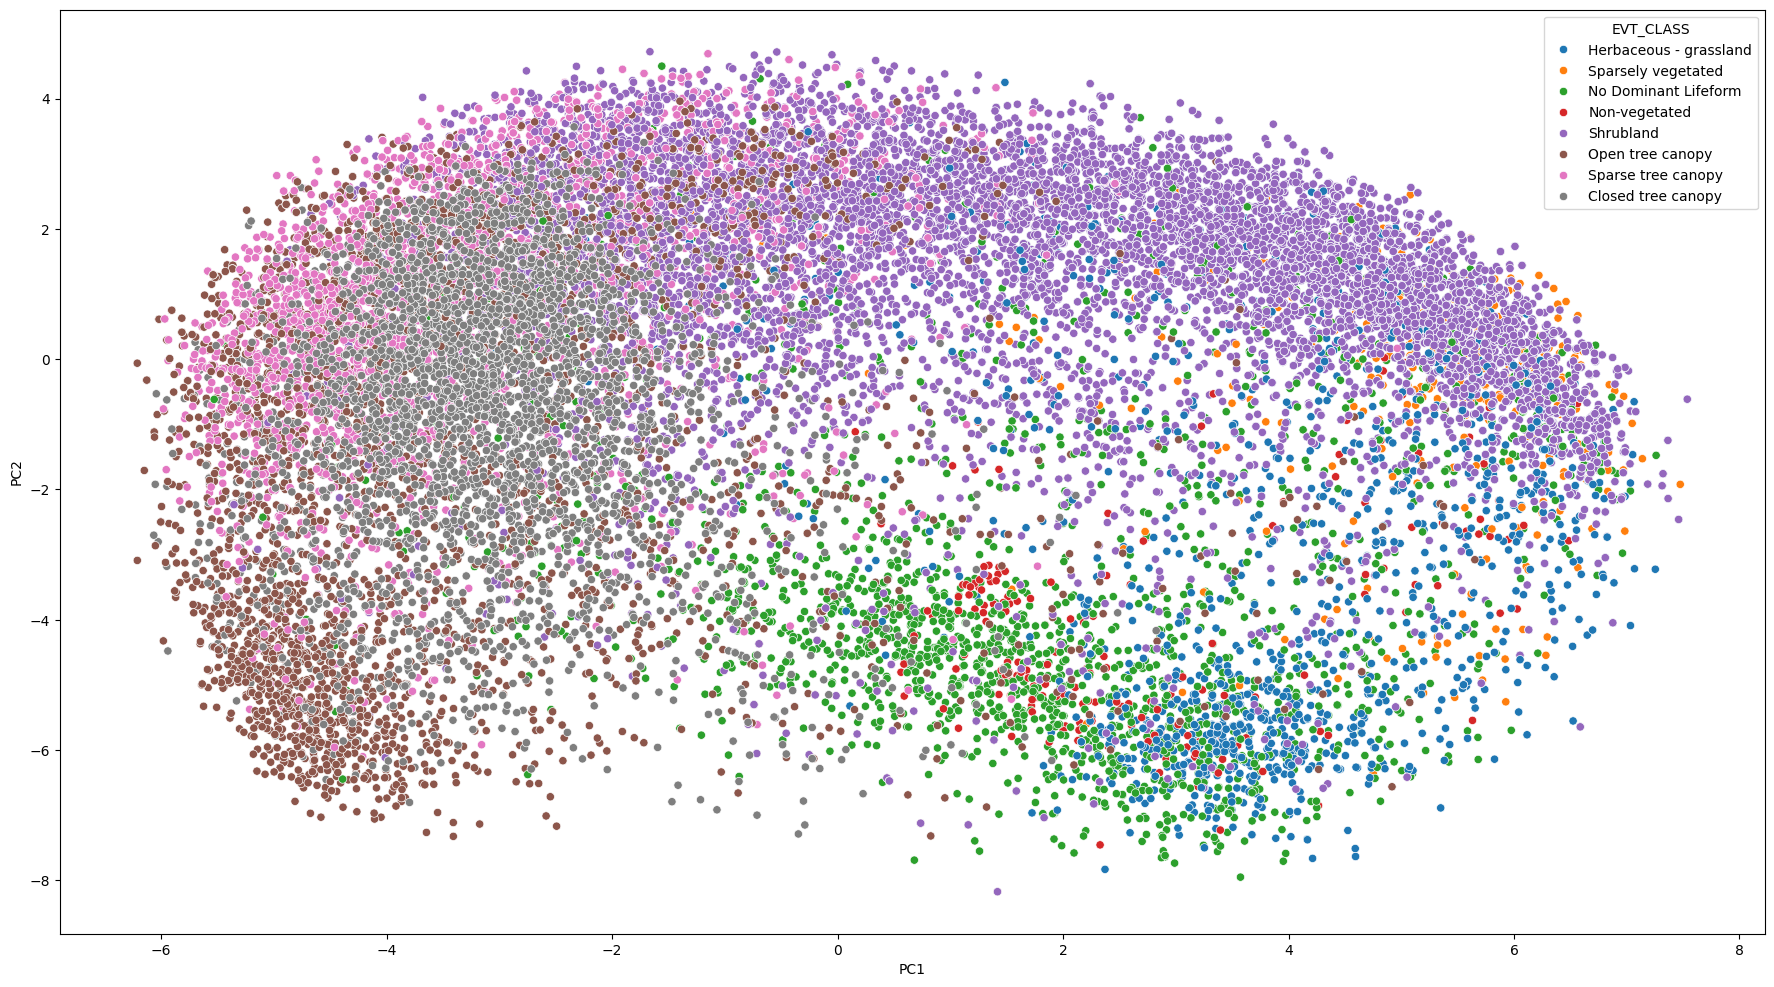

In [31]:
plt.figure(figsize=(22,12))

sns.scatterplot(fuels_sample_viz,x='PC1',y='PC2',hue='EVT_CLASS')

In [32]:
from sklearn.manifold import TSNE

tsne = TSNE(
    n_components=2,
    perplexity=60,
    early_exaggeration=12,
    max_iter=2000,
    n_jobs=-1
)

fuels_tsne = tsne.fit_transform(fuels_inputs_alphaearth_scaled)

fuels_sample_viz['TSNE1'] = fuels_tsne[:,0]
fuels_sample_viz['TSNE2'] = fuels_tsne[:,1]

<Axes: xlabel='TSNE1', ylabel='TSNE2'>

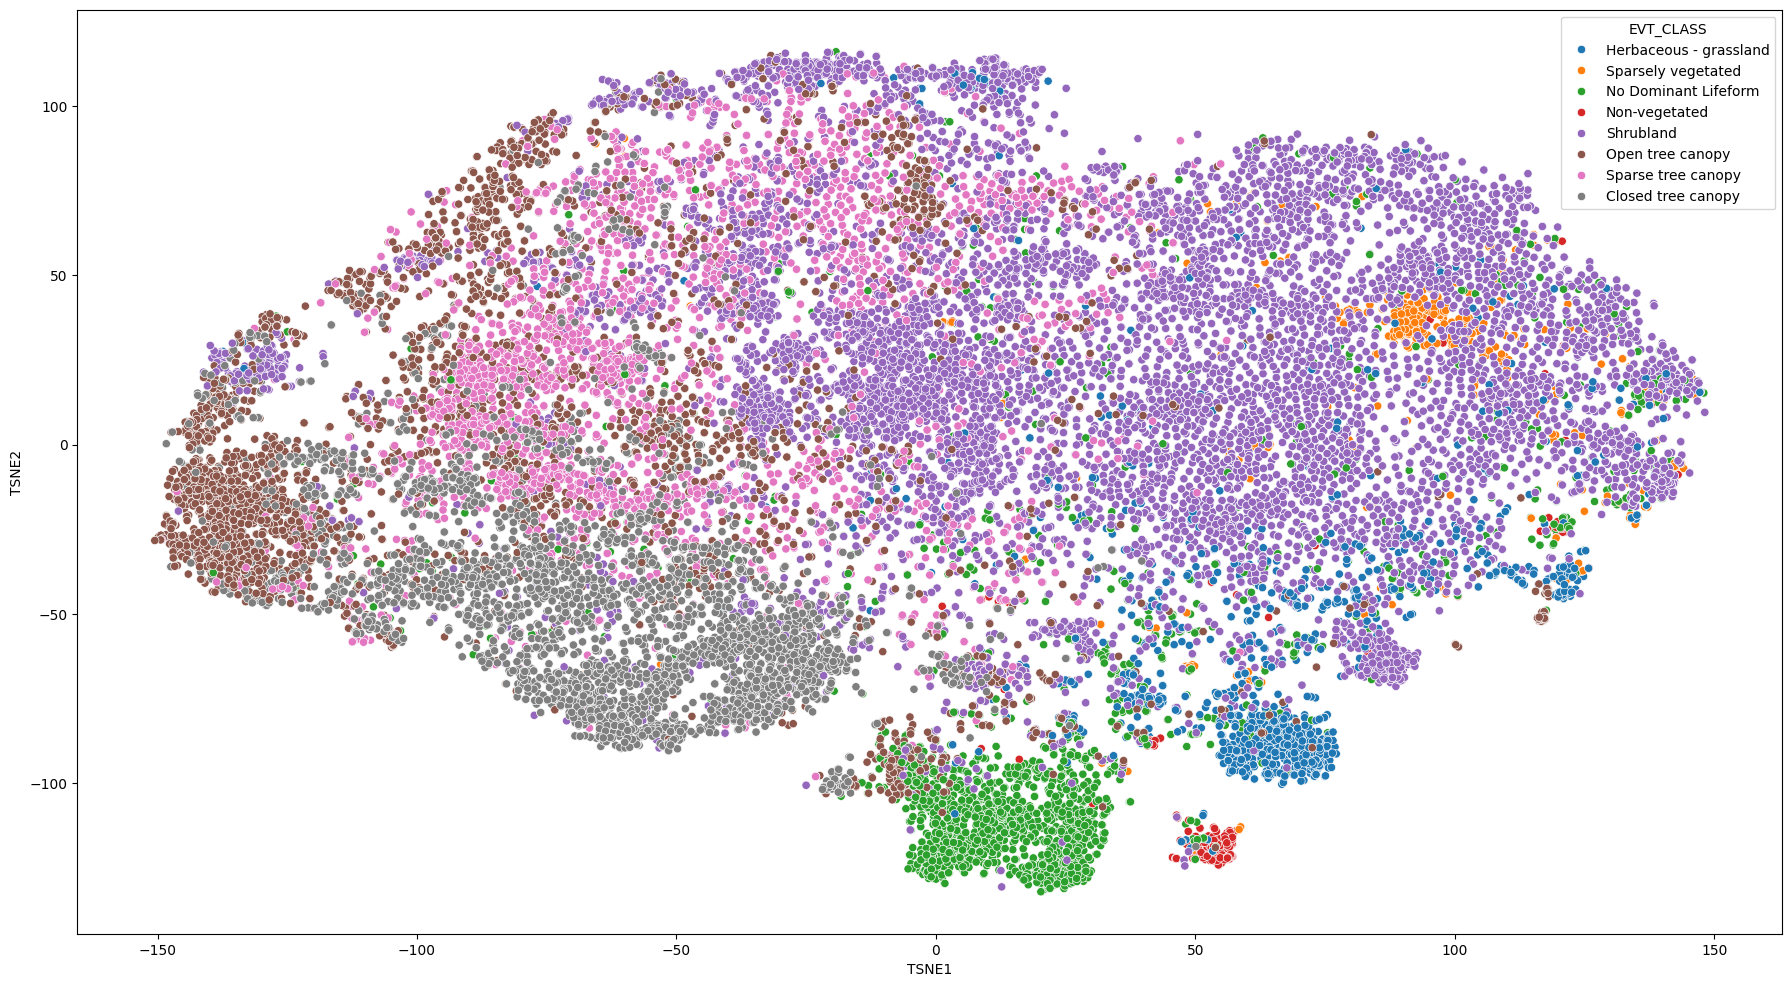

In [33]:
plt.figure(figsize=(22,12))

sns.scatterplot(fuels_sample_viz,x='TSNE1',y='TSNE2',hue='EVT_CLASS')

In [ ]:
from sklearn.neighbors import KNeighborsClassifier



In [ ]:
# import pyretechnics.fuel_models as pfm


# m_per_ft = 0.3048
# s_per_min = 60


# def compute_sigma(fm):
#     """
#     Computes the effective SAV ratio for a fuel model, in ft^{-1}.
#     """
#     sigmas = fm['sigma']
#     w_o = fm['w_o']
#     rho_p = fm['rho_p']
#     s = 0.0
#     At = 0.0
#     for w, r, sigma in zip(w_o, rho_p, sigmas):
#         Aij = sigma * w / r
#         At += Aij
#         s += Aij * sigma
#     if At == 0.0:
#         return 0.0
#     sigma = s / At
#     return sigma


# def compute_beta_op(sigma_per_ft: float) -> float:
#     if sigma_per_ft == 0.0:
#         return 0.0
#     return 3.348 * (sigma_per_ft ** -0.8189)


# def compute_mean_packing_ratio(fm: dict) -> float:
#     delta = fm['delta']
#     w_o = fm['w_o']
#     rho_p = fm['rho_p']
#     s = 0.0
#     for w, r in zip(w_o, rho_p):
#         s += w / r
#     if delta == 0.0:
#         return 0.0
#     beta = s / delta
#     return beta


# def fuel_model_categorization(fm: dict) -> dict:
#     n = fm['number']
#     fuel_class = None
#     fuel_suffix = 0
#     if n < 20: # Anderson fuel models
#         fuel_suffix = f'A{n % 20}'
#         if n <= 4:
#             fuel_class = 'Grass'
#         if n > 4 and n <= 6:
#             fuel_class = 'Shrub'
#         if n == 7:
#             fuel_class = 'Timber Understory'
#         if n > 7 and n <= 10:
#             fuel_class = 'Timber Litter'
#         if n > 10:
#             fuel_class = 'Slash Blowdown'
#     else: # Scott and Burgan fuel models
#         if n // 10 == 10:
#             fuel_class = 'Grass'
#         if n // 10 == 12:
#             fuel_class = 'Grass-shrub'
#         if n // 10 == 14:
#             fuel_class = 'Shrub'
#         if n // 10 == 16:
#             fuel_class = 'Timber Understory'
#         if n // 10 == 18:
#             fuel_class = 'Timber Litter'
#         if n // 10 == 20:
#             fuel_class = 'Slash Blowdown'
#         fuel_suffix = n % 20
#     return {
#         'fuel_class': fuel_class,
#         'fuel_suffix': fuel_suffix
#     }

# def fuel_model_variables(fm: dict):
#     sigma = compute_sigma(fm)
#     beta_op = compute_beta_op(sigma)
#     beta = compute_mean_packing_ratio(fm)
#     rpr = beta / beta_op
#     return {
#         **{k: fm[k] for k in ['number']},
#         **fuel_model_categorization(fm),
#         'sav_per_m': sigma / m_per_ft,
#         'relative_packing_ratio': rpr
#     }
    
# df_fm = pandas.DataFrame([
#     fuel_model_variables(fm)
#     for fm in pfm.list_fuel_models()
#     if compute_sigma(fm) > 0
# ])

# df_fm